In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from google.colab import files
uploaded = files.upload()

Saving us_holiday.csv to us_holiday.csv
Saving test.csv to test.csv
Saving train.csv to train.csv


In [2]:
import io
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
import holidays
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose #decompose seasonality
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from fbprophet import Prophet
 
train = pd.read_csv(io.BytesIO(uploaded['train.csv']), parse_dates=['date'])

test = pd.read_csv(io.BytesIO(uploaded['test.csv']), parse_dates=['date'])

df_holiday = pd.read_csv(io.BytesIO(uploaded['us_holiday.csv']), parse_dates=['Date'])

df_holiday.info()
train.info()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    66 non-null     datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 656.0 bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


In [3]:
def smape(A, F):
    tmp = 2 * np.abs(F - A) / (np.abs(A) + np.abs(F))
    len_ = np.count_nonzero(~np.isnan(tmp))
    if len_ == 0 and np.nansum(tmp) == 0: # Deals with a special case
        return 100
    return 100 / len_ * np.nansum(tmp)

# Parameters in Prophet:
## Analysing Dataset to find Seasonality & Holiday Parameters
From the EDA, there is seasonality as well as weekend effects on the dataset. The assumption of holiday being a positive correlation wasn't as clear. A test will be carried out to test the effect when holiday is not applied and applied.

Deeper Analysis on the dataset seasonality and trends
The EDA looked into yearly seasons and trends. This portion will look into weekly, monthly and yearly seasonality.

In [4]:
# storing the dataset data to plot graphs
stores = train['store'].unique()
items = train['item'].unique()

Sales_series = []
IndexSale_series = []
Dates = []

count = 0
for store in stores:
    for item in items:
        sales = train[(train.store==store) & (train.item==item)]['sales'].to_list() # get all the sales of (store, item) pair
        dates = train[(train.store==store) & (train.item==item)]['date'].to_list() # get all the respective dates
        index = [count, item, store]

        Dates.append(dates)
        Sales_series.append(sales)
        IndexSale_series.append(index)
        
        count +=1

In [5]:
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

# Weekly Seasonality

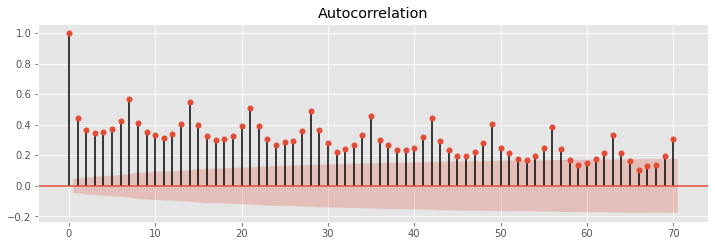

In [6]:
# Check for weekly seasonality using ACF
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(211)
fig = plot_acf(Sales_series[0],lags=70,ax=ax)

# Monthly Seasonality

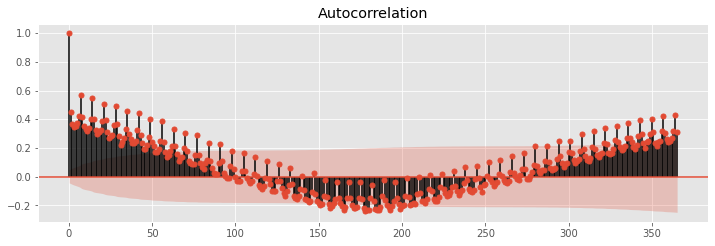

In [7]:
# Check for monthly seasonality using ACF
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(211)
fig = plot_acf(Sales_series[0],lags=365,ax=ax)

# Yearly Seasonality

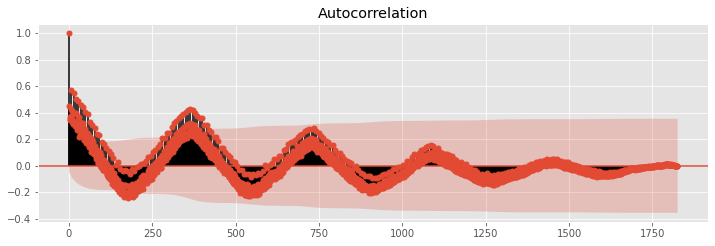

In [8]:
# Check for yearly seasonality using ACF
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(211)
fig = plot_acf(Sales_series[0],lags=1825,ax=ax)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



SAMPE is:  14.196848333657774


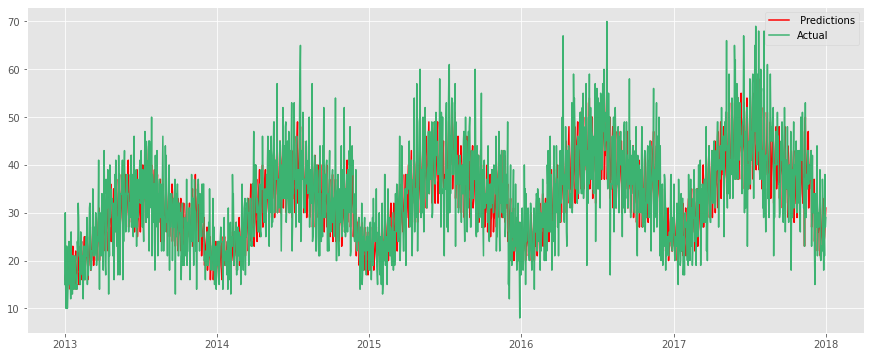

In [9]:
train = train.copy()
test = test.copy()
holidays = df_holiday.copy()
train['date'] = pd.to_datetime(train['date']) 


df = train[train['store'] == 1][train['item'] == 3]
dftemp = train[train['store'] == 1][train['item'] == 3]

df["sales"] = np.log1p(df["sales"])
df = df[["date", "sales"]]
df = df.rename(columns = {"date":"ds","sales":"y"})
df.ds=pd.to_datetime(df.ds,format='%Y-%m')

model = Prophet(daily_seasonality=False,
  weekly_seasonality=True,
  yearly_seasonality=True,
  seasonality_mode='additive',)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.add_country_holidays(country_name='US')
model.fit(df)
future = model.make_future_dataframe(periods = 90)

forecast = model.predict(future)
forecast['yhat'] =  np.expm1(forecast['yhat'])
forecast['yhat'] =  np.round(forecast['yhat']).astype(int)
preds = forecast['yhat'][:-90] # get predicted sales from all dates other than the predicted 90 days

sampe_err = smape(dftemp['sales'].to_numpy(), preds.to_numpy())
print("SAMPE is: ", sampe_err)

plt.figure(figsize=(15,6))
plt.plot(df.ds, preds, color='red', label =' Predictions')
plt.plot(df.ds, dftemp.sales, color='mediumseagreen', label ='Actual')
plt.legend()
plt.style.use('ggplot')
plt.show()

In [10]:
df = train.copy()
test = test.copy()
holidays = df_holiday.copy()

df['date'] = pd.to_datetime(df['date']) 

In [11]:
train = pd.read_csv(io.BytesIO(uploaded['train.csv']), parse_dates=['date'], index_col=['date'])

test = pd.read_csv(io.BytesIO(uploaded['test.csv']), parse_dates=['date'], index_col=['date'])


results = test.reset_index()
results['sales'] = 0

stores = df['store'].unique()
items = df['item'].unique()

for store in stores :
    for item in items:        
        to_train = train.loc[(train['store'] == store) & (train['item'] == item)].reset_index()
        to_train.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True) # rename column to ds and y
        
        to_train['y'] = np.log1p(to_train['y']) 
        
        model = Prophet(
            daily_seasonality=False,
            weekly_seasonality=True,
            yearly_seasonality=True,
            seasonality_mode='additive') # setting model parameters 
        model.add_country_holidays(country_name='US')
        model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
        model.fit(to_train[['ds', 'y']]) # fit data into model
        
        future = model.make_future_dataframe(periods=len(test.index.unique()), include_history=False) 
        forecast = model.predict(future) # make prediction
        
        results.loc[(results['store'] == store) & (results['item'] == item),'sales'] = np.expm1(forecast['yhat']).values # store result and convert log back 

results.drop(['date', 'store', 'item'], axis=1, inplace=True) # drop columns that kaggle don't require
results['sales'] = np.round(results['sales'],2) # round the result to 2 decimal
results.to_csv('Prophet.csv', index=False)



In [12]:
files.download("Prophet.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      45000 non-null  int64  
 1   sales   45000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 703.2 KB
